In [144]:
library(dplyr)
library(lubridate)
library(ggplot2)

In [579]:
default_home_value <- 300000
default_down_payment <- home_value * 0.2
default_interest_rate <- 0.038
# term_yrs <- 30
start_date <- floor_date(unit='month', today()+ months(1)) 
default_payment <- 1401
yearly_costs <- 3400
print(paste('downPayment:', down_payment))

[1] "downPayment: 60000"


In [599]:
month_seq <- seq(start_date,start_date+years(60), by = 'months')

In [600]:
default_payment_schedule <- tibble(month_date = month_seq, 
                           standard_payment = rep(default_payment,times=length(month_seq)),
                                   payment = default_payment)

In [601]:
override_payment_schedule <- function(override_payments, standard_payment_schedule){
    payment_schedule <- standard_payment_schedule %>%
    left_join(override_payments) %>%
    mutate(
    payment = ifelse(
        is.na(override_payment), 
        standard_payment, 
        override_payment))
    return(payment_schedule)
}

In [602]:
mortgage_calc <- function(home_value, down_payment, interest_rate, payment_schedule, tag) {
    current_value = home_value - down_payment
first_payment = 0
next_value= current_value*(1+interest_rate/12)-first_payment
df <- tibble(month_date = start_date, 
             current_value = current_value, 
             payment = first_payment,
             interest=0,
             next_value)
for (month_index in 1:length(month_seq)){
    this_payment <- payment_schedule[[month_index, 'payment']]
    this_interest <- next_value*(interest_rate/12)
    next_value <- next_value + this_interest - this_payment + yearly_costs/12
    temp_df<-tibble(
        month_date = month_seq[month_index], 
             current_value =  ifelse(next_value> 0, next_value, 0), 
             payment = ifelse(next_value> 0, this_payment, 0),
        interest = this_interest,
             next_value = ifelse(next_value> 0, next_value, 0)
            )
    df <- df %>% rbind(temp_df)
    
}
    result_df <- df %>% 
   filter(next_value > 0) %>%
mutate(
    cum_payment = cumsum(payment),
    cum_interest = cumsum(interest)
) %>% 
     mutate(tag=tag) 
    return(result_df)
                             }

In [603]:
test_mortgage_df <- mortgage_calc(default_home_value, default_down_payment, default_interest_rate, default_payment_schedule, 'standard')
testthat::expect_equal(test_mortgage_df[[nrow(test_mortgage_df),'cum_payment']],507162)

In [604]:
test_mortgage_df %>% head()

month_date,current_value,payment,interest,next_value,cum_payment,cum_interest,tag
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2020-08-01,240000.0,0,0.0000,240760.0,0,0.0000,standard
2020-08-01,240404.7,1401,762.4067,240404.7,1401,762.4067,standard
2020-09-01,240048.4,1401,761.2817,240048.4,2802,1523.6883,standard
2020-10-01,239690.8,1401,760.1531,239690.8,4203,2283.8415,standard
2020-11-01,239332.2,1401,759.0210,239332.2,5604,3042.8625,standard
2020-12-01,238972.4,1401,757.8853,238972.4,7005,3800.7478,standard


In [613]:
standard_payment <- 3500
standard_payment_schedule <- tibble(month_date = month_seq, 
                           standard_payment = rep(standard_payment,times=length(month_seq)),
                                   payment = standard_payment)

In [618]:
override_payments <-
tibble(month_date = 20200901, override_payment=2500) %>%
rbind(tibble(month_date = 20201001, override_payment=2500)) %>%
rbind(tibble(month_date = 20201101, override_payment=2500)) %>%
rbind(tibble(month_date = 20201201, override_payment=2500)) %>%
mutate(month_date = ymd(month_date))

In [619]:
full_value <- 380000
down <- 0.2 * full_value
down

[1] 76000

In [620]:
standard_mortgage_df <- mortgage_calc(full_value, down, 0.02657, standard_payment_schedule, 'standard')
override_mortgage_df <- mortgage_calc(full_value, down, 0.02657, override_payment_schedule(override_payments,standard_payment_schedule), 'override')

Joining, by = "month_date"



In [621]:
mortgage_df <- rbind(standard_mortgage_df,override_mortgage_df)
mortgage_df %>% 
group_by(tag) %>%
arrange(desc(month_date)) %>%
slice(1)

month_date,current_value,payment,interest,next_value,cum_payment,cum_interest,tag
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2029-06-01,3158.218,3500,14.08387,3158.218,370500,38668.45,override
2029-05-01,1342.966,3500,10.07348,1342.966,371000,37636.53,standard


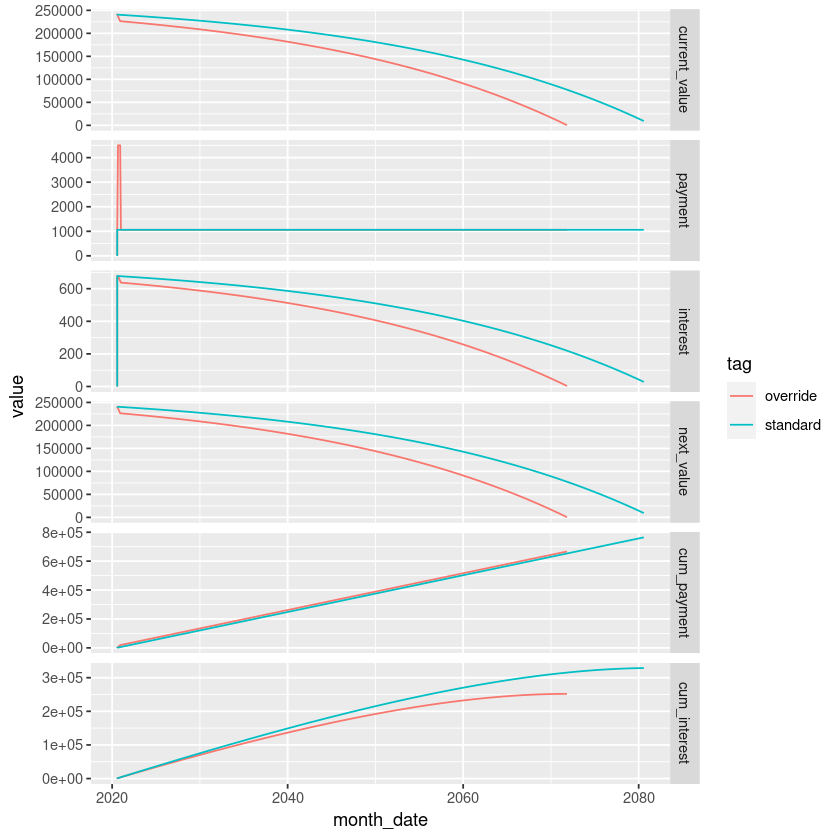

In [609]:
mortgage_df %>%
reshape2::melt(id.vars=c('month_date', 'tag')) %>%
ggplot(aes(x=month_date, y= value, color=tag)) +
geom_line() +
facet_grid(variable ~. , scales = 'free')

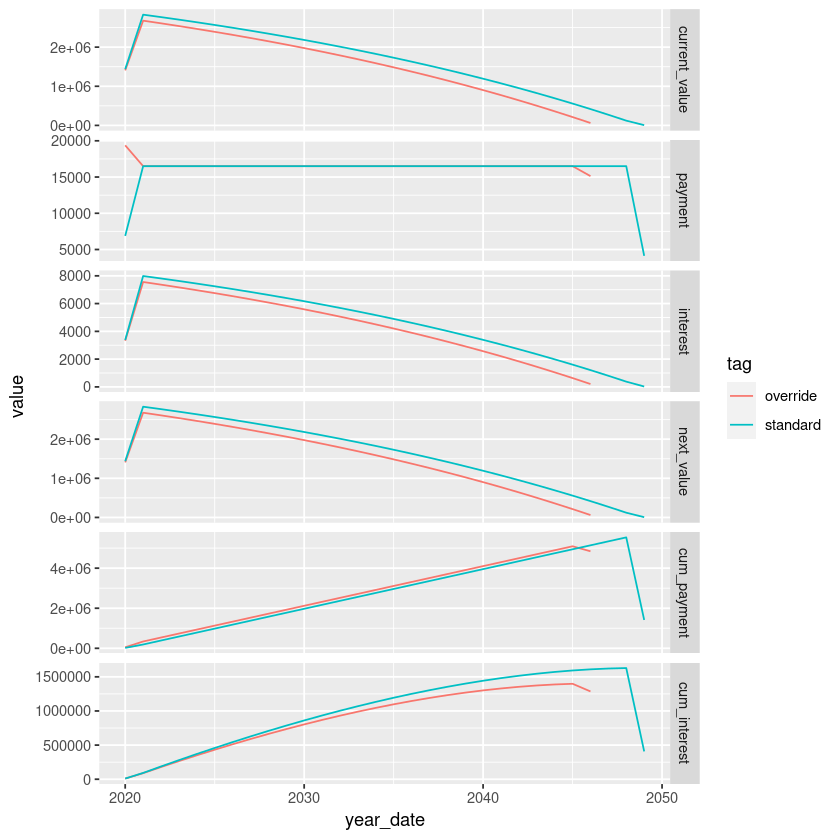

In [594]:
mortgage_df %>%
mutate(year_date = floor_date(unit='year', month_date )) %>%
select(-month_date) %>%
group_by(year_date, tag) %>%
summarise_all(sum) %>%
reshape2::melt(id.vars=c('year_date', 'tag')) %>%
# head()
ggplot(aes(x=year_date, y= value, color=tag)) +
geom_line() +
facet_grid(variable ~. , scales = 'free')